In [1]:
import torch
import detectron2

!nvcc --version

TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]

print(f"torch: {TORCH_VERSION}; cuda: {CUDA_VERSION}")

print(f"detectron2: {detectron2.__version__}")

/home/nachum/berat/anaconda3/envs/torchenv/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243
torch: 1.10; cuda: 1.10.0
detectron2: 0.6


In [2]:
torch.cuda.current_device()
torch.cuda.set_device(1)
torch.cuda.current_device()

1

In [3]:
import os
import json
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt

import detectron2
from detectron2.utils.logger import setup_logger
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import Visualizer
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2 import model_zoo

setup_logger()


<Logger detectron2 (DEBUG)>

In [4]:
from detectron2.data.datasets import register_coco_instances

register_coco_instances("textline_detection_train", {}, "textline_detection_data/textline_detection_labels_train.json", "textline_detection_data/textline_detection_images_train")

register_coco_instances("textline_detection_validation", {}, "textline_detection_data/textline_detection_labels_validation.json", "textline_detection_data/textline_detection_images_validation")



In [5]:
textline_detection_train_metadata = MetadataCatalog.get("textline_detection_train")
train_dataset_dicts = DatasetCatalog.get("textline_detection_train")

[01/06 02:19:03 d2.data.datasets.coco]: Loaded 31 images in COCO format from textline_detection_data/textline_detection_labels_train.json


In [6]:
textline_detection_validation_metadata = MetadataCatalog.get("textline_detection_validation")
validation_dataset_dicts = DatasetCatalog.get("textline_detection_validation")

[01/06 02:19:03 d2.data.datasets.coco]: Loaded 5 images in COCO format from textline_detection_data/textline_detection_labels_validation.json


In [7]:
textline_detection_validation_metadata

namespace(name='textline_detection_validation',
          json_file='textline_detection_data/textline_detection_labels_validation.json',
          image_root='textline_detection_data/textline_detection_images_validation',
          evaluator_type='coco',
          thing_classes=['textline'],
          thing_dataset_id_to_contiguous_id={1: 0})

In [8]:
textline_detection_train_metadata

namespace(name='textline_detection_train',
          json_file='textline_detection_data/textline_detection_labels_train.json',
          image_root='textline_detection_data/textline_detection_images_train',
          evaluator_type='coco',
          thing_classes=['textline'],
          thing_dataset_id_to_contiguous_id={1: 0})

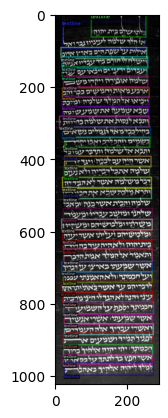

In [9]:
# visualize a random training sample
for d in random.sample(train_dataset_dicts, 1):
    img = cv2.imread(d["file_name"])
    
    # create a visualizer and draw the dataset dict
    visualizer = Visualizer(img, metadata=textline_detection_train_metadata, scale=1)
    out = visualizer.draw_dataset_dict(d)
    
    # Convert the resulting image to rgb and show
    plt.imshow(out.get_image()[:, :, ::-1])

In [10]:
from detectron2.engine import DefaultTrainer

# create a config object and set its properties
cfg = get_cfg()

# load the Faster R-CNN model configuration
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))

# set the dataset sources for training, validation, and testing
cfg.DATASETS.TRAIN = ("textline_detection_train",)
cfg.DATASETS.VAL = ("textline_detection_validation",)
cfg.DATASETS.TEST = ()

# set the number of workers for data loading
cfg.DATALOADER.NUM_WORKERS = 2

# set the initial weights for the model
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml") 

# set the number of detections per image for testing
cfg.TEST.DETECTIONS_PER_IMAGE = 100

# set the number of images per batch for training
cfg.SOLVER.IMS_PER_BATCH = 5

# set the initial learning rate for the optimizer
cfg.SOLVER.BASE_LR = 0.0001  

# set the maximum number of iterations for training
cfg.SOLVER.MAX_ITER = 2500

# set the steps for learning rate decay
cfg.SOLVER.STEPS = []

# set the batch size for the RoI head
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   

# set the number of classes for the RoI head
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  

# set the evaluation period for testing
cfg.TEST.EVAL_PERIOD = 30


In [11]:
from detectron2.engine import HookBase
from detectron2.data import build_detection_train_loader
import detectron2.utils.comm as comm

class ValidationLoss(HookBase):
    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg.clone()
        # Set validation dataset for this hook
        self.cfg.DATASETS.TRAIN = cfg.DATASETS.VAL
        # Build the validation data loader
        self._loader = iter(build_detection_train_loader(self.cfg))
        
    def after_step(self):
        # Get the next batch of data from the validation data loader
        data = next(self._loader)
        with torch.no_grad():
            # Compute the model's loss on the validation data
            loss_dict = self.trainer.model(data)
            
            # Sum all the loss values
            losses = sum(loss_dict.values())
            assert torch.isfinite(losses).all(), loss_dict

            # Reduce loss values across all processes
            loss_dict_reduced = {"val_" + k: v.item() for k, v in 
                                 comm.reduce_dict(loss_dict).items()}
            losses_reduced = sum(loss for loss in loss_dict_reduced.values())
            
            # Save the reduced loss values to the storage for this trainer
            if comm.is_main_process():
                self.trainer.storage.put_scalars(total_val_loss=losses_reduced, 
                                                 **loss_dict_reduced)


In [12]:
# Initialize a DefaultTrainer with the given configuration
trainer = DefaultTrainer(cfg) 

# Initialize a ValidationLoss hook with the given configuration
val_loss = ValidationLoss(cfg)

# Register the ValidationLoss hook with the trainer
trainer.register_hooks([val_loss])
trainer._hooks = trainer._hooks[:-2] + trainer._hooks[-2:][::-1]
trainer.resume_or_load(resume=False)

# Start the training process
trainer.train()


[01/06 02:19:48 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, we

[01/06 02:19:50 d2.engine.train_loop]: Starting training from iteration 0


/home/nachum/berat/anaconda3/envs/torchenv/lib/python3.7/site-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/home/nachum/berat/anaconda3/envs/torchenv/lib/python3.7/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272168290/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[01/06 02:20:26 d2.utils.events]:  eta: 0:34:41  iter: 19  total_loss: 3.641  loss_cls: 0.7012  loss_box_reg: 0.2802  loss_rpn_cls: 1.963  loss_rpn_loc: 0.5486  total_val_loss: 3.755  val_loss_cls: 0.7151  val_loss_box_reg: 0.2058  val_loss_rpn_cls: 2.124  val_loss_rpn_loc: 0.6428  time: 0.8357  data_time: 0.0553  lr: 1.9981e-06  max_mem: 6072M
[01/06 02:20:52 d2.utils.events]:  eta: 0:34:46  iter: 39  total_loss: 2.578  loss_cls: 0.689  loss_box_reg: 0.5071  loss_rpn_cls: 0.7831  loss_rpn_loc: 0.4801  total_val_loss: 2.763  val_loss_cls: 0.7005  val_loss_box_reg: 0.4186  val_loss_rpn_cls: 0.9956  val_loss_rpn_loc: 0.5895  time: 0.9007  data_time: 0.0313  lr: 3.9961e-06  max_mem: 6072M
[01/06 02:21:18 d2.utils.events]:  eta: 0:35:40  iter: 59  total_loss: 2.016  loss_cls: 0.6616  loss_box_reg: 0.8219  loss_rpn_cls: 0.1533  loss_rpn_loc: 0.3944  total_val_loss: 2.129  val_loss_cls: 0.6716  val_loss_box_reg: 0.7237  val_loss_rpn_cls: 0.2636  val_loss_rpn_loc: 0.4627  time: 0.8959  data_t

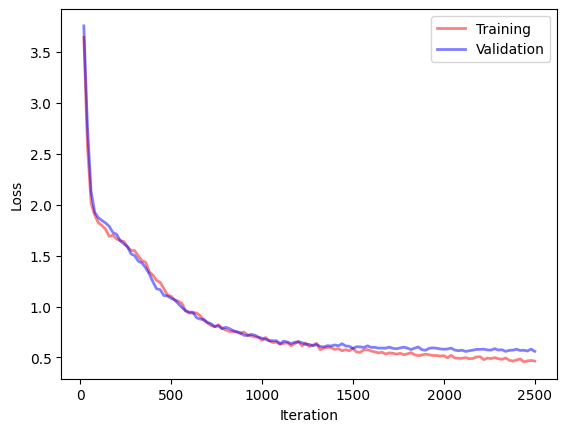

In [13]:
import pandas as pd

# Load the training and validation loss from the metrics.json file
df = pd.read_json('output/metrics.json', lines=True)

# Create a figure and axis object
fig, ax = plt.subplots()

# Plot the training loss as a red line
df.plot(x='iteration', y='total_loss', kind='line', ax=ax, c='red', linewidth=2.0, alpha=0.5, label='Training')

# Plot the validation loss as a blue line
df.plot(x='iteration', y='total_val_loss', kind='line', ax=ax, c='blue', linewidth=2.0, alpha=0.5, label='Validation')

# Set the x-axis label
plt.xlabel('Iteration')

# Set the y-axis label
plt.ylabel('Loss')

# Show the plot
plt.show()


In [23]:
# Save the figure as a png image with 300 dpi
fig.savefig('output/loss.png', format='png', dpi=300)


In [14]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.95   # set a custom testing threshold

# create a predictor
predictor = DefaultPredictor(cfg)


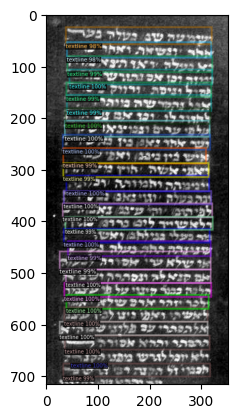

In [16]:
# Randomly select an image from the validation dataset to visualize the prediction results
for d in random.sample(validation_dataset_dicts, 1):
    # Load the image
    im = cv2.imread(d["file_name"])
    
    # Perform inference using the trained model on the image
    outputs = predictor(im)
    
    # Create a visualizer object to draw the prediction results
    v = Visualizer(im, metadata=textline_detection_validation_metadata, scale=1)
    
    # Draw the instance predictions on the image
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    

    # Convert the resulting image to rgb and show
    plt.imshow(out.get_image()[:, :, ::-1])


In [17]:
print(outputs)

{'instances': Instances(num_instances=26, image_height=716, image_width=352, fields=[pred_boxes: Boxes(tensor([[ 35.0617, 519.8504, 318.5832, 546.5880],
        [ 37.5808, 493.8286, 318.2463, 520.0013],
        [ 36.0062, 205.8268, 316.3407, 237.2382],
        [ 31.5418, 366.3922, 321.2129, 392.5148],
        [ 34.1244, 342.2936, 319.2534, 367.9641],
        [ 36.2418, 621.7443, 316.3781, 649.0552],
        [ 25.7135, 594.6006, 311.7848, 621.1907],
        [ 34.3332, 415.0067, 316.1550, 442.1752],
        [ 47.7295, 646.2005, 314.8190, 675.7885],
        [ 37.4337, 182.2508, 316.8776, 211.6302],
        [ 39.0483, 542.8497, 313.8336, 569.7685],
        [ 31.6249, 232.5787, 317.0304, 261.5991],
        [ 34.5592, 566.8224, 311.5112, 594.6286],
        [ 44.9451, 106.8636, 320.8689, 136.4512],
        [ 39.1755, 311.6887, 315.3814, 343.1790],
        [ 33.3362, 287.6746, 313.6984, 314.8741],
        [ 32.6420, 258.8695, 309.3820, 288.7926],
        [ 42.0384, 438.8036, 317.7289, 467.6833

In [18]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

# Create COCOEvaluator and build the test loader
evaluator = COCOEvaluator("textline_detection_validation", output_dir="./output")
val_loader = build_detection_test_loader(cfg, "textline_detection_validation")

# Perform inference and print evaluation results on test set
print(inference_on_dataset(predictor.model, val_loader, evaluator))


[01/06 03:27:25 d2.data.datasets.coco]: Loaded 5 images in COCO format from textline_detection_data/textline_detection_labels_validation.json
[01/06 03:27:25 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[01/06 03:27:25 d2.data.common]: Serializing 5 elements to byte tensors and concatenating them all ...
[01/06 03:27:25 d2.data.common]: Serialized dataset takes 0.00 MiB
[01/06 03:27:25 d2.evaluation.evaluator]: Start inference on 5 batches
[01/06 03:27:25 d2.evaluation.evaluator]: Total inference time: 0:00:00.117782 (0.117782 s / iter per device, on 1 devices)
[01/06 03:27:25 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:00 (0.071389 s / iter per device, on 1 devices)
[01/06 03:27:25 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[01/06 03:27:25 d2.evaluation.coco_evaluation]: Saving results to ./output/coco_instances_results.